# Catégorisation automatique des questions

## Nettoyage et analyse exploratoire

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer 
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# Importation des données

In [48]:
QueryResult = pd.read_csv("/home/alseny/Documents/Proje5_NLP/Donnees/QueryResults.csv")
QueryResult.head()

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount
0,4,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,<c#><floating-point><type-conversion><double><...,801,73678,13,4
1,6,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,<html><css><internet-explorer-7>,321,24022,7,0
2,9,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>,2222,807241,74,11
3,11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,1647,200348,41,3
4,13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,709,293498,27,10


# Nettoyage et exploration des données

In [49]:
QueryResult.info() # Structure des données

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46514 entries, 0 to 46513
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            46514 non-null  int64 
 1   Title         46514 non-null  object
 2   Body          46514 non-null  object
 3   Tags          46514 non-null  object
 4   Score         46514 non-null  int64 
 5   ViewCount     46514 non-null  int64 
 6   AnswerCount   46514 non-null  int64 
 7   CommentCount  46514 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.8+ MB


In [50]:
def Data_NAN(data): # analyse des valeurs manquantes
    
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

In [51]:
Data_NAN(QueryResult)

,Taux de complétion,Nombre de valeurs manquantes
Id,100,0
Title,100,0
Body,100,0
Tags,100,0
Score,100,0
ViewCount,100,0
AnswerCount,100,0
CommentCount,100,0


In [52]:
QueryResult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46514 entries, 0 to 46513
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            46514 non-null  int64 
 1   Title         46514 non-null  object
 2   Body          46514 non-null  object
 3   Tags          46514 non-null  object
 4   Score         46514 non-null  int64 
 5   ViewCount     46514 non-null  int64 
 6   AnswerCount   46514 non-null  int64 
 7   CommentCount  46514 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.8+ MB


In [53]:
# Extraction des mots-clés 
for i in range(len(QueryResult)):
    QueryResult["Tags"][i] = re.sub("><", ",", QueryResult["Tags"][i])
    QueryResult["Tags"][i] = re.sub(r">|<", "", QueryResult["Tags"][i])
    QueryResult["Tags"][i] = QueryResult["Tags"][i].split(",") # séparation des phrases en liste de mots

/tmp/ipykernel_4072/2200443682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QueryResult["Tags"][i] = re.sub("><", ",", QueryResult["Tags"][i])
/tmp/ipykernel_4072/2200443682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QueryResult["Tags"][i] = re.sub(r">|<", "", QueryResult["Tags"][i])
/tmp/ipykernel_4072/2200443682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QueryResult["Tags"][i] = QueryResult["Tags"][i].split("

In [65]:
 QueryResult.head()

,Tags,Posts
0,"[c#, floating-point, type-conversion, double, ...",How to convert Decimal to Double in C#? I want...
1,"[html, css, internet-explorer-7]",Why did the width collapse in the percentage w...
2,"[c#, .net, datetime]",How do I calculate someone's age based on a Da...
3,"[c#, datetime, time, datediff, relative-time-s...",Calculate relative time in C# Given a specific...
4,"[html, browser, timezone, user-agent, timezone...",Determine a user's timezone Is there a standar...


## Fréquence de distribution des tags

In [57]:
Tags_tokens = [token for token_list in QueryResult.Tags for token in token_list]
unique_tags = set(Tags_tokens)
Tags_word_freq = pd.DataFrame(nltk.FreqDist(Tags_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
Tags_word_freq.sort_values("frequency", ascending=False, inplace=True)
first_50_tags = Tags_word_freq[0:50].index.to_list()
first_50_tags

['c#',
 '.net',
 'java',
 'c++',
 'asp.net',
 'javascript',
 'python',
 'php',
 'sql',
 'sql-server',
 'windows',
 'html',
 'c',
 'visual-studio',
 'database',
 'mysql',
 'jquery',
 'css',
 'ruby',
 'performance',
 'linux',
 'asp.net-mvc',
 'winforms',
 'xml',
 'wpf',
 'ruby-on-rails',
 'svn',
 'language-agnostic',
 'unit-testing',
 'algorithm',
 'iphone',
 'vb.net',
 'regex',
 'visual-studio-2008',
 'multithreading',
 'perl',
 'string',
 'security',
 'version-control',
 'linq',
 'oop',
 'oracle',
 'delphi',
 'eclipse',
 'user-interface',
 'debugging',
 'macos',
 'exception',
 'web-services',
 'winapi']

Text(0.5, 1.0, '50 Top tags les plus fréquents')

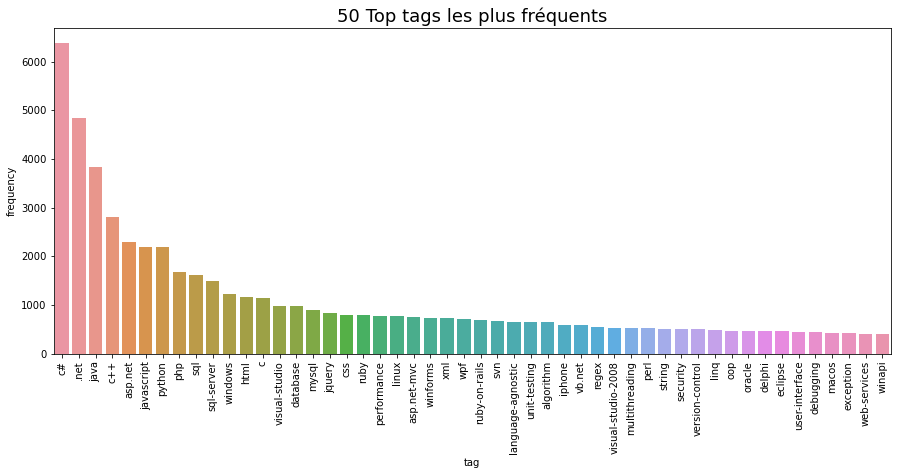

In [58]:
# Visualisation du Top 50 des tags
fig = plt.figure(figsize=(15, 6))
sns.barplot(data=Tags_word_freq.iloc[0:50, :],
            x=Tags_word_freq.iloc[0:50, :].index,y="frequency")
plt.xticks(rotation=90)
plt.title("50 Top tags les plus fréquents", fontsize=18)

## Présentation des textes  sur les posts 

Text(0.5, 1.0, 'Les textes du corps')

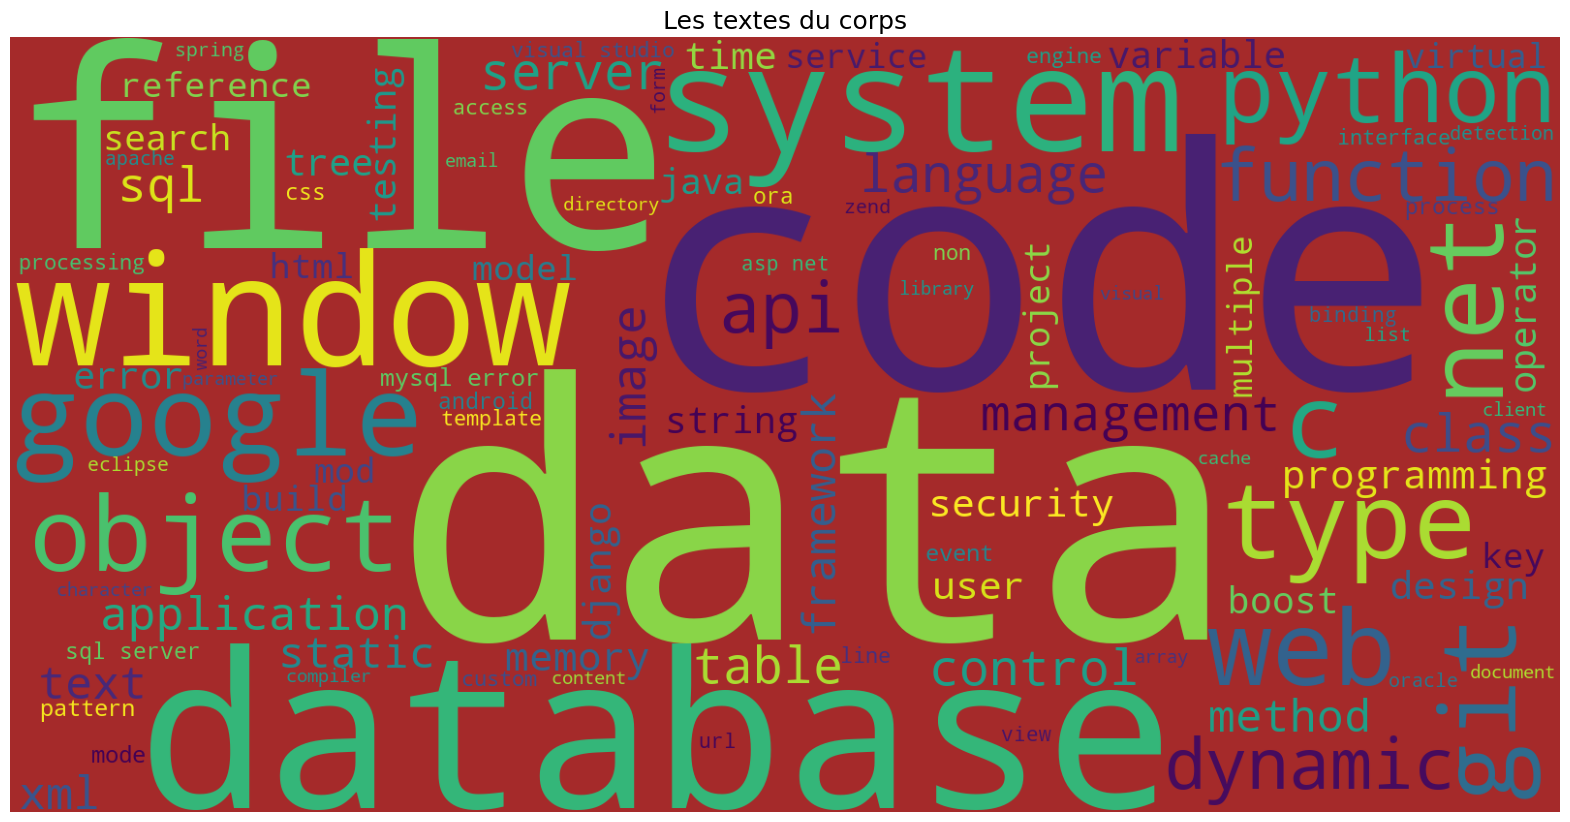

In [138]:
txt_tags = " ".join(unique_tags) 
fig = plt.figure(figsize=(20,18))
wordcloud = WordCloud(background_color = 'brown',width=1600, height=800, max_words = 100).generate(txt_tags)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Les textes du corps",fontsize=18)

## Suppression des balises html sur le corps des textes

In [59]:
def remove_html(x):
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)
QueryResult.Body = QueryResult['Body'].apply(lambda text: remove_html(text))
QueryResult.Body = [BeautifulSoup(text,"lxml").get_text() for text in QueryResult.Body]

In [60]:
QueryResult.head()

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount
0,4,How to convert Decimal to Double in C#?,"I want to assign the decimal variable ""trans"" ...","[c#, floating-point, type-conversion, double, ...",801,73678,13,4
1,6,Why did the width collapse in the percentage w...,I have an absolutely positioned containing s...,"[html, css, internet-explorer-7]",321,24022,7,0
2,9,How do I calculate someone's age based on a Da...,"Given a representing a person's birthday, ho...","[c#, .net, datetime]",2222,807241,74,11
3,11,Calculate relative time in C#,"Given a specific value, how do I display rel...","[c#, datetime, time, datediff, relative-time-s...",1647,200348,41,3
4,13,Determine a user's timezone,Is there a standard way for a web server to be...,"[html, browser, timezone, user-agent, timezone...",709,293498,27,10


## Featur ingenering

In [61]:
# jointure entre les variables "Title" et "Body"
QueryResult["Posts"] = QueryResult["Title"] + " " + QueryResult["Body"]
QueryResult.drop(columns = ["Body", "Title", "Score", "ViewCount", "AnswerCount", "CommentCount", "Id"], inplace = True) # Suppression des colonnes

In [62]:
QueryResult.head()

,Tags,Posts
0,"[c#, floating-point, type-conversion, double, ...",How to convert Decimal to Double in C#? I want...
1,"[html, css, internet-explorer-7]",Why did the width collapse in the percentage w...
2,"[c#, .net, datetime]",How do I calculate someone's age based on a Da...
3,"[c#, datetime, time, datediff, relative-time-s...",Calculate relative time in C# Given a specific...
4,"[html, browser, timezone, user-agent, timezone...",Determine a user's timezone Is there a standar...


In [63]:
#Nombre de mots avant nettoyage
print(QueryResult['Posts'].apply(lambda x: len(x.split(' '))).sum())

4790980


## convertion des textes en minuscules, suppression des ponctuations et mots unitiles

In [20]:
import re
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    
# Nettoyer (convertir en minuscules et supprimer les ponctuations et les caractères spéciaux
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (Convertion de chaîne en liste)
    lst_text = text.split(" ")
    
    lst_text = list(filter(lambda x: len(x) > 3 , lst_text))

    # Suppression de  Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convertir le mot en mot racine)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # # retour à la chaîne de la liste
    text = " ".join(lst_text)
    return text
 # Application de la fonction à l'ensemble du corpus
QueryResult["PostsClean"] = QueryResult["Posts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
#df.head()

In [22]:
QueryResult.head()

,Tags,Posts,PostsClean
0,"[c#, floating-point, type-conversion, double, ...",How to convert Decimal to Double in C#? I want...,convert decimal double want assign decimal var...
1,"[html, css, internet-explorer-7]",Why did the width collapse in the percentage w...,width collapse percentage width child element ...
2,"[c#, .net, datetime]",How do I calculate someone's age based on a Da...,calculate someone based datetime type birthday...
3,"[c#, datetime, time, datediff, relative-time-s...",Calculate relative time in C# Given a specific...,calculate relative time given specific value d...
4,"[html, browser, timezone, user-agent, timezone...",Determine a user's timezone Is there a standar...,determine user timezone standard server able d...


In [23]:
#Nombre de mots après nettoyage
print(QueryResult['PostsClean'].apply(lambda x: len(x.split(' '))).sum())

2172660


## Selection des 10 premiers tags pour la modélisation

In [28]:
Tags_tokens = [token for token_list in QueryResult.Tags for token in token_list]
unique_tags = set(Tags_tokens)
Tags_word_freq = pd.DataFrame(nltk.FreqDist(Tags_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
Tags_word_freq.sort_values("frequency", ascending=False, inplace=True)
first_10_tags = Tags_word_freq[0:10].index.to_list()

In [29]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in first_10_tags:
            tags_filtered.append(tags[i])
    return tags_filtered

In [35]:
QueryResult['Tags'] = QueryResult['Tags'].apply(lambda x: most_common(x))
QueryResult['Tags'] =QueryResult['Tags'].apply(lambda x: x if len(x)>0 else None) # Suppression des lignes vides
QueryResult.dropna(inplace = True)
QueryResult = QueryResult.reset_index(drop = True)
QueryResult.head()

,Tags,Posts,PostsClean
0,[c#],How to convert Decimal to Double in C#? I want...,convert decimal double want assign decimal var...
1,"[c#, .net]",How do I calculate someone's age based on a Da...,calculate someone based datetime type birthday...
2,[c#],Calculate relative time in C# Given a specific...,calculate relative time given specific value d...
3,[.net],Difference between Math.Floor() and Math.Trunc...,difference mathfloor mathtruncate difference
4,[c#],Filling a DataSet or a DataTable from a LINQ q...,filling dataset datatable linq query result ex...


In [37]:
# Nombre d'observation après nettoyage
QueryResult.shape 

(24839, 3)

Text(0.5, 1.0, '10 Top tags les plus fréquents')

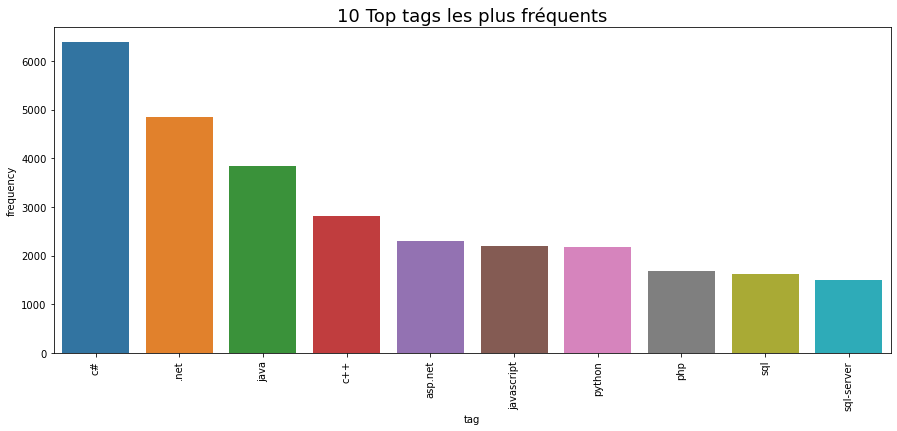

In [38]:
# Visualisation de 10 tags sélectionnés
fig = plt.figure(figsize=(15, 6))
sns.barplot(data=Tags_word_freq.iloc[0:10, :],
            x=Tags_word_freq.iloc[0:10, :].index,y="frequency")
plt.xticks(rotation=90)
plt.title("10 Top tags les plus fréquents", fontsize=18)

## Sauvegarde des données propres

In [150]:
QueryResult.to_csv("QueryResultCleaneed.csv", index = False, sep = ',')